In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree

import SweetSpotPrediction as ssp

# Base Case read data

In [2]:
# File paths with corresponding map names
files_names = {'Data\\thickness\\thickness': 'Thickness'
         , 'Data\\avgntg\\avgntgasc': 'AvgNTG'
         , 'Data\\avgperm\\avgpermasc': 'AvgPerm'
         , 'Data\\avgporo\\avgporoasc': 'AvgPoro'
         , 'Data\\netperm\\netpermasc': 'NetPerm'
               
         , 'Data\\sweetspot.txt': 'SweetSpot'
              }

# Read map files
dfs = []
spacing = 50 # map grid cell dimension
for key in files_names:
    df = pd.read_csv(key, delimiter=' ', comment='#', names=['XPos', 'YPos', files_names[key], 'c1', 'c2'])
    df.drop(columns=['c1', 'c2'], inplace=True)
    df_reg = ssp.make_regular(df, files_names[key], spacing)
    df_reg.set_index(['XPos','YPos'], inplace=True)
    dfs = dfs + [df_reg]

# Merge dataframes
df = pd.concat(dfs, axis='columns', join='inner').reset_index()

In [3]:
features = [
    #'XPos', # propbably dont want these as features
    #'YPos', # propbably dont want these as features
    'Thickness',
    'AvgNTG',
    'AvgPerm',
    'AvgPoro',
    'NetPerm',

]

label_clf = 'SweetSpot' 

# Data cleaning

In [4]:
# Functions to drop values less than zero or greater than one

def drop_neg(x):
    if x < 0:
        return np.nan
    else:
        return x

def drop_gt1(x):
    if x > 1:
        return np.nan
    else:
        return x
    
def zero_to_one(x):
    if x < 0.2:
        return 0
    else:
        return 1

In [5]:
def clean_columns(df):

    # Clean dataframe according to specified columns to remove negatives or greater than one
    df_clean = df.copy()

    cols_remove_negs = set(df_clean.columns) - {'XPos', 'YPos', 'SweetSpot'}
    cols_remove_gt1 = {'AvgNTG', 'WellProbability'}
    cols_limit_zero_to_one = { 'SweetSpot'}


    for col in df_clean.columns:
        if col in cols_remove_negs:
            df_clean[col] = df_clean[col].apply(drop_neg)
        if col in cols_remove_gt1:
            df_clean[col] = df_clean[col].apply(drop_gt1)
        if col in cols_limit_zero_to_one:
            df_clean[col] = df_clean[col].apply(zero_to_one)
    df_clean.dropna(inplace=True)
    return df_clean

In [6]:
df_clean = clean_columns(df)

In [7]:
df_clean.SweetSpot = df_clean.SweetSpot.fillna(0).round().astype('int64')

# Goal: Sweet Spots 

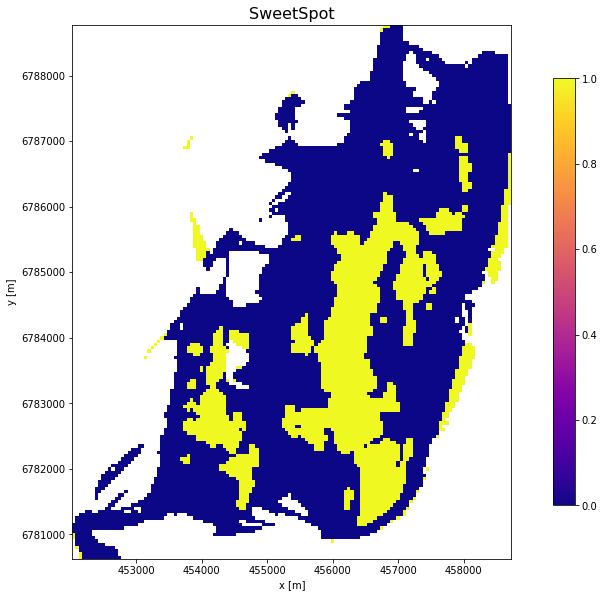

In [8]:
ssp.plot_map(df_clean, 'SweetSpot', dtype='cat')

# Train Model

In [9]:
X_train, X_, y_train, y_ = train_test_split(df_clean[features], df_clean[label_clf], test_size=0.33, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.50, random_state=42)

# Normalization and other preprocessing

In [10]:
preprocessing = StandardScaler()
X_train = preprocessing.fit_transform(X_train)
#X_test = preprocessing.transform(X_test)
X_val = preprocessing.transform(X_val)

# Model Scores

In [11]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_pred_val = model.predict(X_val)
ssp.ReportMetrics(model, X_train, X_val, y_train, y_val, y_pred_val)

Precision: 0.677
Recall: 0.795
F1: 0.731


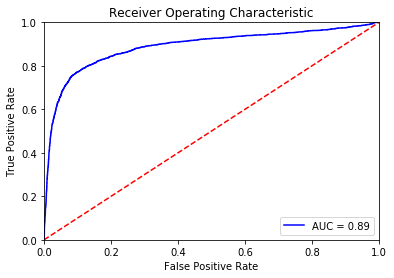

In [12]:
from sklearn.metrics import roc_curve, auc
df_clean['prediction_prob'] = model.predict_proba(preprocessing.transform(df_clean[features]))[:,1]

fpr, tpr, threshold = roc_curve(df_clean[label_clf], df_clean['prediction_prob'] )

roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Uncertainties

In [13]:
files_thickness = ['Data\\thickness\\thickness','Data\\thickness\\thickness_fake']
files_ntg = ['Data\\avgntg\\avgntgasc']
files_AvgPerm =['Data\\avgperm\\avgpermasc']
files_AvgPoro =['Data\\avgporo\\avgporoasc']
files_NetPerm =['Data\\netperm\\netpermasc']

import itertools
files=[ files_thickness,files_ntg,files_AvgPerm,files_AvgPoro,files_NetPerm ]
sets = list(itertools.product(*files))

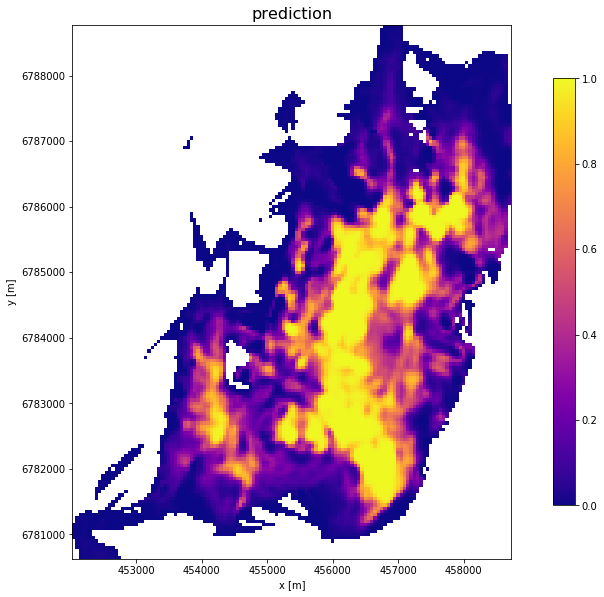

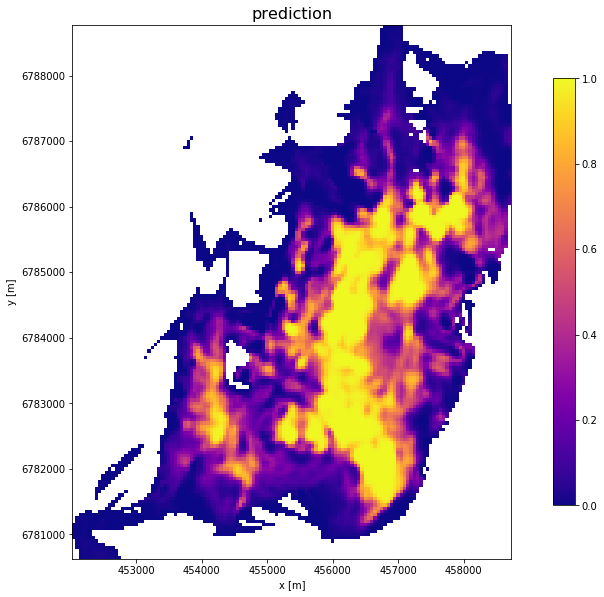

In [14]:
for singlePermutation in sets:
    files_names = {singlePermutation[0]: 'Thickness'
         , singlePermutation[1]: 'AvgNTG'
         , singlePermutation[2]: 'AvgPerm'
         , singlePermutation[3]: 'AvgPoro'
         , singlePermutation[4]: 'NetPerm'
               }
    # Read map files
    dfs = []
    spacing = 50 # map grid cell dimension
    for key in files_names:
        df = pd.read_csv(key, delimiter=' ', comment='#', names=['XPos', 'YPos', files_names[key], 'c1', 'c2'])
        df.drop(columns=['c1', 'c2'], inplace=True)
        df_reg = ssp.make_regular(df, files_names[key], spacing)
        df_reg.set_index(['XPos','YPos'], inplace=True)
        dfs = dfs + [df_reg]

    # Merge dataframes
    df = pd.concat(dfs, axis='columns', join='inner').reset_index()
    df_clean = clean_columns(df)
    df_clean['prediction'] = model.predict_proba(preprocessing.transform(df_clean[features]))[:,1]
    ssp.plot_map(df_clean, 'prediction', dtype='cat')
    